# PM2.5 Forecasting using LSTM

## Tujuan

Notebook ini bertujuan untuk membangun model Deep Learning berbasis
Long Short-Term Memory (LSTM) untuk memprediksi nilai PM2.5
berdasarkan pola historis data kualitas udara.

Model digunakan untuk:
- Mempelajari pola time-series PM2.5
- Melakukan forecasting jangka pendek
- Mengevaluasi performa prediksi menggunakan RMSE dan R²

# Import Library

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Wrangling

## Gathering Data
load dan read data

Dataset difokuskan pada satu station untuk menjaga konsistensi pola time-series.

In [50]:
# membaca data
data = pd.read_csv('/content/drive/MyDrive/air_condition/dataset/cleaned_air_quality_data.csv')
data.sample(5)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Temp_Category,datetime,year_month
379760,2016,6,26,8,35.0,80.0,2.0,19.0,400.0,65.0000,27.8,998.1,14.1,0.0,WSW,1.4,Dingling,Normal (0°C - 30°C),2016-06-26 08:00:00,2016-06
305786,2016,1,18,2,11.0,58.0,4.0,9.0,400.0,64.0000,-8.1,1018.7,-23.9,0.0,NW,3.6,Gucheng,Dingin (< 0°C),2016-01-18 02:00:00,2016-01
111572,2013,11,21,20,85.0,101.0,37.0,64.0,1700.0,4.7124,3.9,1017.2,-7.3,0.0,N,1.6,Changping,Normal (0°C - 30°C),2013-11-21 20:00:00,2013-11
253507,2014,1,30,19,129.0,178.0,57.0,129.0,1600.0,27.0000,4.1,1012.6,-9.0,0.0,S,2.7,Wanliu,Normal (0°C - 30°C),2014-01-30 19:00:00,2014-01
207524,2016,11,1,20,73.0,130.0,7.0,81.0,900.0,2.0000,1.7,1027.7,-3.2,0.0,NE,0.9,Shunyi,Normal (0°C - 30°C),2016-11-01 20:00:00,2016-11


In [51]:
# mengambil data station Nongzhanguan
data_Nongzhanguan = data[data['station'] == 'Nongzhanguan']
data_Nongzhanguan.sample(5)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Temp_Category,datetime,year_month
5056,2013,9,27,16,255.0,271.0,49.0,66.0,1400.0,221.0,23.1,1005.2,10.2,0.0,SE,1.5,Nongzhanguan,Normal (0°C - 30°C),2013-09-27 16:00:00,2013-09
25577,2016,1,30,17,40.0,41.0,17.0,59.0,1100.0,32.0,-2.7,1030.2,-21.0,0.0,WSW,2.4,Nongzhanguan,Dingin (< 0°C),2016-01-30 17:00:00,2016-01
13971,2014,10,4,3,76.0,76.0,6.0,29.0,1200.0,49.0,14.6,1012.9,13.0,0.1,SSW,2.4,Nongzhanguan,Normal (0°C - 30°C),2014-10-04 03:00:00,2014-10
30145,2016,8,8,1,53.0,73.0,2.0,35.0,1300.0,53.0,26.3,1006.0,22.6,0.0,SE,1.8,Nongzhanguan,Normal (0°C - 30°C),2016-08-08 01:00:00,2016-08
12006,2014,7,14,6,19.0,27.0,4.0,59.0,500.0,8.0,24.0,999.1,16.0,0.0,NE,1.6,Nongzhanguan,Normal (0°C - 30°C),2014-07-14 06:00:00,2014-07


## Data Assessing

mengecek data duplicate, null, statistik, dan informasi data

In [52]:
# mengecek informasi dataset
data_Nongzhanguan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 0 to 35063
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           35064 non-null  int64  
 1   month          35064 non-null  int64  
 2   day            35064 non-null  int64  
 3   hour           35064 non-null  int64  
 4   PM2.5          35064 non-null  float64
 5   PM10           35064 non-null  float64
 6   SO2            35064 non-null  float64
 7   NO2            35064 non-null  float64
 8   CO             35064 non-null  float64
 9   O3             35064 non-null  float64
 10  TEMP           35064 non-null  float64
 11  PRES           35064 non-null  float64
 12  DEWP           35064 non-null  float64
 13  RAIN           35064 non-null  float64
 14  wd             35064 non-null  object 
 15  WSPM           35064 non-null  float64
 16  station        35064 non-null  object 
 17  Temp_Category  35064 non-null  object 
 18  datetime   

In [53]:
# mengecek data null
data_Nongzhanguan.isna().sum()

,0
year,0
month,0
day,0
hour,0
PM2.5,0
PM10,0
SO2,0
NO2,0
CO,0
O3,0


In [54]:
# mengecek data duplicate
data_Nongzhanguan.duplicated().sum()

np.int64(0)

In [55]:
# mengetahui data statistik dataset
data_Nongzhanguan.describe()


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,2014.662560,6.522930,15.729637,11.500000,84.304073,108.652398,18.540560,57.799225,1309.754991,58.339367,13.671962,1012.546194,2.447907,0.063983,1.860601
std,1.177213,3.448752,8.800218,6.922285,85.541269,94.788708,24.161282,35.999068,1226.006366,58.000981,11.455167,10.263259,13.806765,0.786059,1.280146
min,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.571200,2.000000,100.000000,0.214200,-16.800000,987.100000,-35.300000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,5.750000,23.000000,38.000000,3.000000,30.000000,500.000000,10.000000,3.100000,1004.000000,-8.800000,0.000000,1.000000
50%,2015.000000,7.000000,16.000000,11.500000,57.000000,84.000000,9.000000,50.000000,900.000000,45.000000,14.600000,1012.200000,3.100000,0.000000,1.500000
75%,2016.000000,10.000000,23.000000,17.250000,114.000000,148.000000,23.000000,79.000000,1600.000000,83.000000,23.500000,1020.900000,15.000000,0.000000,2.400000
max,2017.000000,12.000000,31.000000,23.000000,844.000000,995.000000,257.000000,273.000000,10000.000000,390.000000,41.100000,1042.000000,28.800000,46.400000,10.500000


##Cleaning Data

melakukan pembersihan data

In [56]:
print(data_Nongzhanguan.columns)

Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station',
       'Temp_Category', 'datetime', 'year_month'],
      dtype='object')


In [57]:

# mengubah kolom tahun, bulan, hari, dan jam mejadi satu kolom datetime
data_Nongzhanguan['datetime'] = pd.to_datetime(
    data_Nongzhanguan[['year', 'month', 'day', 'hour']]
)

data_Nongzhanguan['datetime'].sample(5)

/tmp/ipython-input-2619889980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Nongzhanguan['datetime'] = pd.to_datetime(


,datetime
1919,2013-05-19 23:00:00
16365,2015-01-11 21:00:00
32245,2016-11-03 13:00:00
10914,2014-05-29 18:00:00
62,2013-03-03 14:00:00


In [58]:
# menyisakan data polutan saja
data_Nongzhanguan = data_Nongzhanguan.drop(
    columns=['year', 'month', 'day', 'hour', 'station',
             'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']
)
data_Nongzhanguan.head()

,PM2.5,PM10,SO2,NO2,CO,O3,Temp_Category,datetime,year_month
0,5.0,14.0,4.0,12.0,200.0,85.0,Dingin (< 0°C),2013-03-01 00:00:00,2013-03
1,8.0,12.0,6.0,14.0,200.0,84.0,Dingin (< 0°C),2013-03-01 01:00:00,2013-03
2,3.0,6.0,5.0,14.0,200.0,83.0,Dingin (< 0°C),2013-03-01 02:00:00,2013-03
3,5.0,5.0,5.0,14.0,200.0,84.0,Dingin (< 0°C),2013-03-01 03:00:00,2013-03
4,5.0,5.0,6.0,21.0,200.0,77.0,Dingin (< 0°C),2013-03-01 04:00:00,2013-03


In [59]:
# Menghapus kolom yang tidak terpakai saat modeling

data_Nongzhanguan = data_Nongzhanguan.drop(
    columns=['Temp_Category','year_month'], axis=1
)
data_Nongzhanguan.head()

,PM2.5,PM10,SO2,NO2,CO,O3,datetime
0,5.0,14.0,4.0,12.0,200.0,85.0,2013-03-01 00:00:00
1,8.0,12.0,6.0,14.0,200.0,84.0,2013-03-01 01:00:00
2,3.0,6.0,5.0,14.0,200.0,83.0,2013-03-01 02:00:00
3,5.0,5.0,5.0,14.0,200.0,84.0,2013-03-01 03:00:00
4,5.0,5.0,6.0,21.0,200.0,77.0,2013-03-01 04:00:00


In [60]:
# Sort datatime
data_Nongzhanguan = data_Nongzhanguan.sort_values('datetime')
# mengubah datetime menjadi index
data_Nongzhanguan.set_index('datetime', inplace=True)

In [61]:
data_Nongzhanguan.sample(5)

,PM2.5,PM10,SO2,NO2,CO,O3
datetime,,,,,,
2014-11-01 03:00:00,196.0,196.0,4.0,106.0000,2800.0,2.0000
2013-12-10 03:00:00,51.0,66.0,35.0,63.4377,900.0,5.5692
2015-12-10 07:00:00,218.0,218.0,39.0,89.0000,4100.0,2.0000
2014-07-09 07:00:00,10.0,43.0,2.0,56.0000,400.0,4.0000
2016-08-03 05:00:00,116.0,116.0,2.0,41.0000,1700.0,49.0000


## Split Data

In [62]:
total = len(data_Nongzhanguan)

train_size = int(total * 0.8)
val_size   = int(total * 0.1)

train_end = train_size
val_end   = train_size + val_size

# Membagi data sebelum scaling untuk mencegah data leakage
train_raw = data_Nongzhanguan.iloc[:train_end]
val_raw   = data_Nongzhanguan.iloc[train_end:val_end]
test_raw  = data_Nongzhanguan.iloc[val_end:]

## 3. Normalisasi Data

Data dinormalisasi menggunakan MinMaxScaler agar model LSTM
dapat belajar dengan lebih stabil.

In [63]:
scaler = MinMaxScaler()

# Fit scaler hanya pada data training
scaler.fit(train_raw)

# Transformasi dan masukkan kembali ke variabel penamaan asli Anda
train = pd.DataFrame(scaler.transform(train_raw), columns=data_Nongzhanguan.columns, index=train_raw.index)
val   = pd.DataFrame(scaler.transform(val_raw), columns=data_Nongzhanguan.columns, index=val_raw.index)
test  = pd.DataFrame(scaler.transform(test_raw), columns=data_Nongzhanguan.columns, index=test_raw.index)

target = 'PM2.5'

X_train = train.drop(columns=[target])
y_train = train[target]

X_val = val.drop(columns=[target])
y_val = val[target]

X_test = test.drop(columns=[target])
y_test = test[target]

## 4. Membuat Sequence Time-Series

Model LSTM membutuhkan data dalam bentuk sequence.
Sequence dibuat menggunakan TimeseriesGenerator.

In [64]:
n_input = 24
batch = 32
n_features = X_train.shape[1]

# Perhatikan: y_train.values digunakan sebagai target
train_gen = TimeseriesGenerator(
    train.values, y_train.values,
    length=n_input, batch_size=batch
)

val_gen = TimeseriesGenerator(
    val.values, y_val.values,
    length=n_input, batch_size=batch
)

test_gen = TimeseriesGenerator(
    test.values, y_test.values,
    length=n_input, batch_size=batch
)


## 5. Arsitektur Model

Model terdiri dari:
- LSTM Layer
- Dropout (untuk mencegah overfitting)
- Dense Output Layer

In [65]:
model = Sequential()

model.add(Input(shape=(n_input, train.shape[1]))) # Menggunakan seluruh kolom input
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

## 6. Training Model

Model dilatih selama 30 epoch dengan optimizer Adam.
Learning rate disesuaikan menggunakan scheduler.

In [67]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0037 - mae: 0.0405 - val_loss: 5.3903e-04 - val_mae: 0.0162 - learning_rate: 0.0010
Epoch 2/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0015 - mae: 0.0233 - val_loss: 3.5616e-04 - val_mae: 0.0131 - learning_rate: 0.0010
Epoch 3/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0012 - mae: 0.0200 - val_loss: 3.0347e-04 - val_mae: 0.0117 - learning_rate: 0.0010
Epoch 4/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0010 - mae: 0.0181 - val_loss: 2.8362e-04 - val_mae: 0.0110 - learning_rate: 0.0010
Epoch 5/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.2731e-04 - mae: 0.0175 - val_loss: 4.2281e-04 - val_mae: 0.0159 - learning_rate: 0.0010
Epoch 6/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0012 - mae: 0.0169 - val_loss: 2.6471e-04 - val_mae: 0.0106 - learning_rate: 2.0000e-04
Epoch 7/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9.4665e-04 - mae: 0.0156 - val_loss: 2.6587e-04 - val_mae: 0.0108 

## 7. Evaluasi Model

Setelah training, model digunakan untuk memprediksi data test.
Nilai dikembalikan ke skala asli menggunakan inverse_transform.

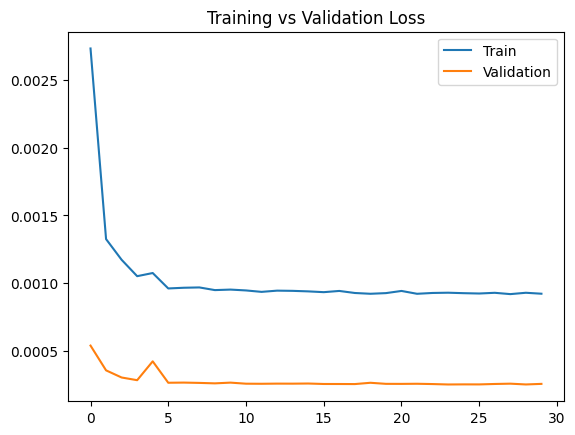

In [68]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [69]:
pred = model.predict(test_gen)


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [70]:
# Inverse Transform menggunakan dummy array agar konsisten dengan 6 kolom asli
dummy = np.zeros((len(pred), data_Nongzhanguan.shape[1]))
dummy[:, 0] = pred.flatten() # PM2.5 ada di kolom index 0

pred_inv = scaler.inverse_transform(dummy)[:, 0]

In [71]:
# Mengambil nilai real (PM2.5) dari data_Nongzhanguan
# Offset n_input diperlukan karena TimeseriesGenerator memotong data awal
real = data_Nongzhanguan[target].values[train_end + val_size + n_input:]

rmse = np.sqrt(mean_squared_error(real, pred_inv))
r2 = r2_score(real, pred_inv)

print("RMSE:", rmse)
print("R2:", r2)


RMSE: 29.15338572934978
R2: 0.9317949269557907


## 8. Visualisasi Actual vs Predicted

Grafik berikut menunjukkan perbandingan antara nilai aktual
dan hasil prediksi model.

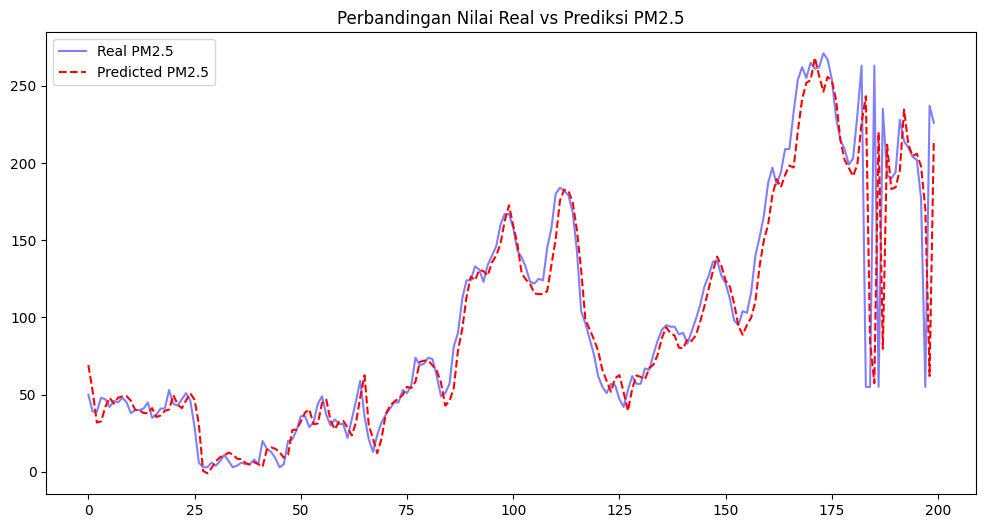

Category
Good              1443
Very Unhealthy     953
Moderate           661
Unhealthy          426
Name: count, dtype: int64


In [72]:
# Membuat dataframe untuk hasil prediksi
df_pred = data_Nongzhanguan.iloc[train_end + val_size + n_input:].copy()
df_pred['Predicted_PM2.5'] = pred_inv

def classify_pm25(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Moderate"
    elif x <= 150:
        return "Unhealthy"
    else:
        return "Very Unhealthy"

df_pred['Category'] = df_pred['Predicted_PM2.5'].apply(classify_pm25)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(real[:200], label='Real PM2.5', color='blue', alpha=0.5)
plt.plot(pred_inv[:200], label='Predicted PM2.5', color='red', linestyle='--')
plt.title("Perbandingan Nilai Real vs Prediksi PM2.5")
plt.legend()
plt.show()

print(df_pred['Category'].value_counts())


In [73]:
model.save("pm25_lstm_model.keras")


In [74]:
model.save("pm25_lstm_model.h5")
